# Supervised Learning: Capstone
### State Farm - Distracted Driver Detection
Practicing **safe driving** at ALL times can test the patience of even the best of us; and while autonomous driving is something to look forward to in the (hopefully near) future, drivers should be reminded to continue to **practice safe driving** until then, and maybe even after, as there are always unintended consequences when it comes to technology. 
<br>

- Specifically in regards to driving, the technology in question is **texting.** Texting/messaging changed the dynamics of phone usage, but especially for those who grew up never not having this functionality in their phones. 
- The average person is likely to have been using their phones for at least a few years before reaching driving age, primarily to communicate with friends.  The problem stems from the **nature of texting, which does not encourage delayed responses.** Additionally, in order to text even faster, teens invent all sorts of abbreviations for commonly used phrases. 
- Even if the more severe cases of [cell-phone addiction](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5076301/) do not apply to all kids who grew up in in the past couple decades, cell-phone addiction is still likely to be present to varying degrees.  We have all likely done things like: 
    - compulsively checking/touching phone;
    - phone-surfing(?) during free time;
    - going to your phone first thing after sleep, last thing before sleep.

Driving requires the full attention of the driver.<br> However, **considering how inseparable we all are from our smartphones** from the moment we first get one (have you never freaked out when you realized you left the house without your phone?), and that **today's generation** of kids are given the latest and best smartphones at an even younger/more influentiable age, it is naive to assume that that type of **behavior will magically stop** with a driver's license. 
<br>
**If phone usage while driving was allowed, they would do so** because it is **not against the law anymore,** disregarding the fact that it is **still dangerous.** 
- In that case, there is little reason to think that these drivers are **ever off their phones,** as even if there was police around, it is likely to be just one car with at most two officers; one officer is driving, and is it expected for the other officer to be able to inspect all of the cars in their vicinity?

**The point of not using phones while driving** is because phones **interfere with the driver's ability to drive**, and the driver that says they are the exception is the driver I want to stay far away from.



Taken from the [Kaggle competition page](https://www.kaggle.com/c/state-farm-distracted-driver-detection) about distracted drivers: <br>
>According to the CDC motor vehicle safety division, one in five car accidents is caused by a distracted driver. Sadly, this translates to 425,000 people injured and 3,000 people killed by distracted driving every year.
<br><br>
State Farm hopes to improve these alarming statistics, and better insure their customers, by testing whether **dashboard cameras** can automatically detect drivers engaging in distracted behaviors. Given a dataset of 2D dashboard camera images, State Farm is challenging Kagglers to classify each driver's behavior. Are they driving attentively, wearing their seatbelt, or taking a selfie with their friends in the backseat?
<br>
<br>


The **solution** to this would be what State Farm is suggesting: **the installation of dashboard cameras,** as constant supervision seems to be only answer for the level of behavior exhibited by the worst offenders.
- already being implemented (https://markets.businessinsider.com/news/stocks/distracted-and-drowsy-driving-detection-now-available-on-idrive-s-x2-camera-system-1027366842)
- also (https://www.marketwatch.com/story/car-insurers-are-tapping-into-tech-to-win-over-customers-2018-08-07)
- and wow (https://spectrum.ieee.org/cars-that-think/transportation/sensors/the-ai-dashcam-app-that-wants-to-rate-every-driver-in-the-world)

The 10 classes to predict are:

- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import random

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction import image
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import utils

import cv2

np.random.seed(42)

In [2]:
from tensorflow import set_random_seed
set_random_seed(42)

import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, Input, ZeroPadding2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.initializers import Constant
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.preprocessing.image import ImageDataGenerator


C:\Users\Ryan\Anaconda3\envs\tensorflow-gpu\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


The code is based on ZFTurbo's thread,  [Keras Sample Code](https://www.kaggle.com/c/state-farm-distracted-driver-detection/discussion/19971)
<br>

***
## Helper Functions

In [3]:
# loads individual image files

def get_im_cv2(path, img_rows, img_cols, color_type=3):
    # color_type, 1 = grayscale; 3 = color
    if color_type == 1:
        img = cv2.imread(path, 0)
    elif color_type == 3:
        img = cv2.imread(path)
    
    # Resize to given input dimensions
    img = img.astype('uint8')
    resized = cv2.resize(img, (img_cols, img_rows))
    resized = resized.astype('float32')

    return resized

In [4]:
# loads driver information (csv format)

def get_driver_data():
    dr = dict()
    path = os.path.join('..', 'supervised', 'statefarm', 'driver_imgs_list.csv')
#     print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
    f.close()
    return dr

In [5]:
# combine X (images, main featureset), driver_id (minor feature used for validation split), and y (target/class)

def make_df(X, y, driver_id, color_type):

    ymebbe = np.dstack((y, driver_id))[0]
    ymebbe_df = pd.DataFrame(data=ymebbe, columns=(('class', 'driver_id')))
    
    X1 = np.reshape(X, (len(X),-1))
    X_df = pd.DataFrame(data=X1)
    df = pd.concat((X_df, ymebbe_df), axis=1).sort_values('driver_id')
    
    return df

In [6]:
# master folder > driver_id.csv containing image file name, class, driver_id  &  10 folders of image files for each class
# > individual image files that are shuffled 

# loads and appends images to list, with its corresponding class and driver_id added to a separate list (all with same index)
# combines X (image dataset), y(multiclass feature), and driver_id into "df"
## simplifies later process of extracting validation set via driver_id
def load_data(num_class, img_rows, img_cols, color_type=3):
    X = []
    y = []
    driver_id = []

    driver_data = get_driver_data()

    print('Read train images')
    for j in range(num_class):
        print('Load folder c{}'.format(j))
        path = os.path.join('..', 'supervised', 'statefarm', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_cv2(fl, img_rows, img_cols, color_type)
            X.append(img)
            y.append(j)
            driver_id.append(driver_data[flbase])

    df = make_df(X, y, driver_id, color_type)
    
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return df, driver_id, unique_drivers

***

In [7]:
# Extract validation set and training set by randomly selecting drivers

def split_val(df, unique_drivers, val=False, drivers_known=[]):

    # random sample 3 drivers to be set aside for val set
    # training set will use drivers not in val set
#     if drivers_known:
#         drivers_val = drivers_known
#     else:
#         drivers_val = random.sample(unique_drivers,3)

    # in order to evaluate model, handpicking drivers
    drivers_val = ['p002', 'p016', 'p056'] 
    
    if val: # extract validation set
        df = df[df.driver_id.apply(lambda x: x in drivers_val)]
    else:
        df = df[df.driver_id.apply(lambda x: x not in drivers_val)]
        df = utils.shuffle(df,random_state=42)
    
    X = df.iloc[:, :-2]
    X = np.asarray(X, dtype='float32')
    
    y = np.asarray(df.loc[:, 'class'])
    unique_dr = sorted(list(set(df.driver_id)))
    
    return X, y, unique_dr

In [8]:
def train_val_split(num_rows, num_cols, num_class, color_type):
    # helper function, loading all the images into df
    df, driver_id, unique_drivers = load_data(num_class, num_rows, num_cols, color_type)  

    # separates validation set from rest of dataset (now training set) using random driver_id
    # separate df into X, y, and driver_id
    X_val, y_val, drivers_val = split_val(df, unique_drivers, val=True)
    X, y, drivers_train = split_val(df, unique_drivers, val=False) # currently not using random driver_id for model evaluation,
                                                                # otherwise requires extra parameter: drivers_known=drivers_val
                                                            # so that train set can be retrieved using the same random driver_ids
                                                            # that was used to retrieve val set
                
    return X, y, X_val, y_val, drivers_val

## Loading Data 

In [13]:
X, y, X_val, y_val, drivers_val = train_val_split(96,128,3,1)

Read train images
Load folder c0
Load folder c1
Load folder c2
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


In [ ]:
# convert probabilities keras_model.predict() to hard predictions
# nine 0s and one 1 (10 class classification) for one sample

def pred_convert(arr):
    arr[arr == np.amax(arr)] = 1
    arr[arr != np.amax(arr)] = 0
    return arr



# calculates hard accuracy scores and confusion matrix for multiclass classification, 
# and converts predictions/test set to binary class: 
## safe and non-safe driving with corresponding accuracy scores and confusion matrix  # will have class imbalance 9-1

def predictions(X_test, y_test, model, skl=False):
    
    y_ = model.predict(X_test)
    
    # logisticRegression models did not have its "y" converted to dummies via to_categorical()
    # futhermore LogisticRegression models give hard prediction/scores already when calling .score(), 
    ## unlike keras models which take into account prediction probabilities (needs verifying)
    if skl == False:
        np.apply_along_axis(lambda x: pred_convert(x), 1, y_);
        
        Y_ = np.argmax(y_,1)
        Y_test = np.argmax(y_test,1)
    
#         print("Converting the probabilities from model.predict() into hard predictions", 
#           "results in an accuracy score of:\n", np.mean(Y_test == Y_), '\n')
        

    
        print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_), '\n\n')
        
        y__ = np.asarray([1 if n[0] == np.amax(n) else 0 for n in y_])
        y_test1 = np.asarray([1 if n[0] == np.amax(n) else 0 for n in y_test])
    
        print("Converting the probabilities from model.predict() into binary predictions of",
          "safe-driving'==1 and 'non-safe driving'==0 results in an accuracy score of:\n", 
         np.mean(y__ == y_test1), '\n')
        print("Confusion Matrix:\n", confusion_matrix(y_test1, y__))
        
    else:
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_), '\n\n')
        
        y__ = np.asarray([1 if n==0 else 0 for n in y_])
        y_test1 = np.asarray([1 if n==0 else 0 for n in y_test])

In [ ]:
lines = '----'

In [ ]:
def demo_v1(X, y, X_val, y_val, drivers_val,
            n_rows, n_cols, model_v, color_type=3, num_class=10, batch_size=32, epochs=10, 
            skl=False, lr=1e-3, aug=False, return_data=False, reduce=False, pca_n=100,
           **kwargs): # kwargs for sklearn model paramters only
     

    
    # if keras model
    ## one-hot-encode the target feature
    ## reshape dataset to (n_samples, n_rows, n_cols, color_type)
    if skl == False:
        y = to_categorical(y, num_classes=num_class)
        y_val = to_categorical(y_val, num_classes=num_class)
        
        X -= np.mean(X)
        X_val -= np.mean(X_val)
        
        X = X.reshape(X.shape[0], n_rows, n_cols, color_type)
        X_val = X_val.reshape(X_val.shape[0], n_rows, n_cols, color_type)
        
        X = X.astype('float32')
        X_val = X_val.astype('float32')
        
        
        model = model_v(n_rows,n_cols,color_type,num_class,epochs,lr=lr)
        
        if aug:
            datagen = ImageDataGenerator(
                zca_whitening=True,
                zca_epsilon=1e-3
                )

            datagen.fit(X, augment=True, rounds=2, seed=42)

            history = model.fit_generator(datagen.flow(X, y, batch_size=batch_size, seed=42, shuffle=True),
                                steps_per_epoch=X.shape[0] // batch_size,
                                epochs=epochs, shuffle=True, 
                                validation_data=(datagen.flow(X_val,y_val,batch_size=batch_size)))


        else:
            datagen = ImageDataGenerator()
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size, seed=42, shuffle=True),
                                steps_per_epoch=X.shape[0] // batch_size,
                                epochs=epochs, shuffle=True, 
                                validation_data=(X_val,y_val))

            
            
    # if sklearn model
    ## reshape dataset to (n_samples, n_rows*n_cols*color_type)
    ## leave y as is (1D-array with 10 class)
    else:
        X = np.reshape(X, (len(X), -1))
        X_val = np.reshape(X_val, (len(X_val), -1))
        model = sklearn_model(model_v, **kwargs)

#         scaler = StandardScaler()
#         X = scaler.fit_transform(X)
#         X_val = scaler.transform(X_val)
        
        if reduce:
            pca = PCA(n_components=pca_n) #   n_rows * n_cols * 0.05
            X = pca.fit_transform(X)
            X_val = pca.transform(X_val)
            
        model.fit(X, y)        
#         model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=model_v, **kwargs)


    print('\nThe drivers that are held out for the validation set are: ', drivers_val)
    

    print('\n\n', lines*4, ''.join((str(n_rows),'/',str(n_cols),'/',str(color_type))), lines*4)


        
    # score/evaluate (sklearn/keras models) and confusion matrix
    if skl:
        # as keras.models have validation_data=(X_test,y_test),
        # sklearn.models require another score/confusion matrix for test data
        
        print('\n\nValidation Score:',
             model.score(X_val, y_val))
    else:
        print('\n\nValidation Score:\n', 
          model.evaluate(X_val, y_val) )       
             
    predictions(X_val, y_val, model, skl=skl)

    if return_data:
        return model, X, y, X_val, y_val
    else:
        return model

- linear
    - logistic regression
    - kmeans
    
- knn
    - pca


In [16]:
def sklearn_model(model, **kwargs):
    m = model(**kwargs)
    return m


***
### KNearestClassifier
- There is **no training**, as this model uses the **distance between the training and test** data to determine classification
- Test images are compared to every single data in the training set
    - computationally **expensive testing**
        - generally, expensive training and shorter testing is preferred
- **Measuring distance over high-dimensional matrices counterintuitive**
    - recommended to reduce dimensionality before proceeding (e.g. PCA)

In [16]:
base_knc = demo_v1(X, y, X_val, y_val, drivers_val,
                   96,128, KNeighborsClassifier, num_class=3, color_type=1, 
                 skl=True, n_neighbors=5, p=1, metric='minkowski')


The drivers that are held out for the validation set are:  ['p002', 'p016', 'p056']


 ---------------- 96/128/1 ----------------


Validation Score: 0.5878634639696586
Confusion Matrix:
 [[132 121  15]
 [ 47 148  61]
 [ 74   8 185]] 




### PCA dimension reduction 

In [20]:
# reduce=True for pca
base_knc_pca = demo_v1(X, y, X_val, y_val, drivers_val,
                       96,128, KNeighborsClassifier, num_class=3, color_type=1, 
                       skl=True, reduce=True, pca_n=150, n_neighbors=5, p=1)


The drivers that are held out for the validation set are:  ['p002', 'p016', 'p056']


 ---------------- 96/128/1 ----------------


Validation Score: 0.5790139064475348
Confusion Matrix:
 [[175  84   9]
 [ 50 204   2]
 [ 73 115  79]] 




As mentioned before, it could be beneficial to apply a dimension reduction for a distance-based classifier/model. 
- a very important parameter for PCA, number of dimensions to keep, is set arbitrarily.  Getting the best scores possible would require determining the optimal parameters.
    - This would likely involve tuning the dimension size of the images. 
    - Shrinking image dimensions can already be seen as a method for dimension reduction, so performing an additional dimension reduction on top of that may not function as desired.


In [42]:
base_linear = demo_v1(X, y, X_val, y_val, drivers_val,
                      96,128, LogisticRegression, num_class=3, color_type=1, 
                     skl=True, solver='sag', multi_class='multinomial', random_state=42, C=1e-4, tol=1e-4,
                      max_iter=150)


The drivers that are held out for the validation set are:  ['p002', 'p016', 'p056']


 ---------------- 96/128/1 ----------------


Validation Score: 0.6460176991150443
Confusion Matrix:
 [[189  53  26]
 [ 72 170  14]
 [ 85  30 152]] 




### Logistic Regression/ Linear Models/ Parametric Approach
- Requires model to learn
    - once model learns, training set no longer needed
- Prediction of a test image is instantaneous
    - a single matrix multiplication with the model's weights
- Loss Function
    - measures compatibility of learned parameters with class labels in training set
    - smaller score is better
        - **Even if accuracy is high, IF MODEL IS UNSURE about its predictions, the THE LOSS SCORE WILL BE HIGH**

In [16]:
def dense_model(img_rows, img_cols, color_type, num_class, epochs, lr=1e-3):
    
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=(img_rows*img_cols))) 
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

### Why ConvNets? 
- ConvNet architectures specifically designed for image inputs
    - easier implementation; reduced number of paramters


In [17]:
# example vgg model from keras 

def create_model_v0(img_rows, img_cols, color_type, num_class, epochs, lr=1e-3):
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='softmax'))

    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
    
#     model.compile(Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [23]:
m0 = demo_v1(X, y, X_val, y_val, drivers_val,
             96,128,create_model_v0, num_class=3, color_type=1, batch_size=96, epochs=5, lr=0.001)


The drivers that are held out for the validation set are:  ['p002', 'p016', 'p056']


 ---------------- 96/128/1 ----------------
Epoch 1/5
65/65 [==============================] - 39s 597ms/step - loss: 1.0795 - acc: 0.4186 - val_loss: 1.0712 - val_acc: 0.5411
Epoch 2/5
65/65 [==============================] - 34s 530ms/step - loss: 0.9566 - acc: 0.5853 - val_loss: 0.9677 - val_acc: 0.6915
Epoch 3/5
65/65 [==============================] - 34s 527ms/step - loss: 0.6190 - acc: 0.7562 - val_loss: 1.0359 - val_acc: 0.6662
Epoch 4/5
65/65 [==============================] - 34s 527ms/step - loss: 0.3984 - acc: 0.8526 - val_loss: 1.3740 - val_acc: 0.5348
Epoch 5/5
791/791 [==============================] - 1s 2ms/step


Validation Score:
 [5.957586789101025, 0.6270543610401612]
Confusion Matrix:
 [[268   0   0]
 [ 74 182   0]
 [105 116  46]] 


Converting the probabilities from model.predict() into binary predictions of safe-driving'==1 and 'non-safe driving'==0 results in an accuracy scor

In [20]:
# example vgg model minus a middle block

def create_model_v1(img_rows, img_cols, color_type, num_class, epochs, lr=1e-3):
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), 
                     activation='relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu',))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu'))
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='softmax'))

    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
    
#     model.compile(Adam(lr=lr, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [26]:
m1 = demo_v1(X, y, X_val, y_val, drivers_val,
             96,128,create_model_v1, num_class=3, color_type=1, batch_size=96, epochs=5, lr=0.001)


The drivers that are held out for the validation set are:  ['p002', 'p016', 'p056']


 ---------------- 96/128/1 ----------------
Epoch 1/5
65/65 [==============================] - 35s 543ms/step - loss: 2.1992 - acc: 0.4221 - val_loss: 1.0637 - val_acc: 0.4905
Epoch 2/5
65/65 [==============================] - 34s 524ms/step - loss: 0.7650 - acc: 0.6775 - val_loss: 1.0138 - val_acc: 0.5449
Epoch 3/5
65/65 [==============================] - 34s 523ms/step - loss: 0.3456 - acc: 0.8818 - val_loss: 1.0339 - val_acc: 0.6713
Epoch 4/5
65/65 [==============================] - 34s 523ms/step - loss: 0.1928 - acc: 0.9382 - val_loss: 1.1460 - val_acc: 0.7029
Epoch 5/5
791/791 [==============================] - 1s 2ms/step


Validation Score:
 [4.714668847239011, 0.681415928676065]
Confusion Matrix:
 [[249  19   0]
 [ 79 177   0]
 [113  41 113]] 


Converting the probabilities from model.predict() into binary predictions of safe-driving'==1 and 'non-safe driving'==0 results in an accuracy score

In [13]:
def create_model_v2(img_rows, img_cols, color_type, num_class, epochs, lr=1e-3):
    
    model = Sequential()  
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu',
                    input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='softmax'))

    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
    
#     model.compile(Adam(lr=lr, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
m2 = demo_v1(X, y, X_val, y_val, drivers_val,
             96,128,create_model_v2, num_class=3, color_type=1, batch_size=80, epochs=5, lr=0.001)


The drivers that are held out for the validation set are:  ['p002', 'p016', 'p056']


 ---------------- 96/128/1 ----------------
Epoch 1/5
78/78 [==============================] - 55s 708ms/step - loss: 0.3985 - acc: 0.8528 - val_loss: 1.3177 - val_acc: 0.6422
Epoch 2/5
78/78 [==============================] - 48s 620ms/step - loss: 0.0654 - acc: 0.9800 - val_loss: 1.3160 - val_acc: 0.6827
Epoch 3/5
78/78 [==============================] - 48s 619ms/step - loss: 0.0402 - acc: 0.9873 - val_loss: 1.2755 - val_acc: 0.7054
Epoch 4/5
78/78 [==============================] - 48s 619ms/step - loss: 0.0357 - acc: 0.9893 - val_loss: 1.0521 - val_acc: 0.7396
Epoch 5/5
791/791 [==============================] - 3s 3ms/step


Validation Score:
 [9.385063735031148, 0.4171934267211654]
Confusion Matrix:
 [[  0 207  61]
 [  0 256   0]
 [  0 193  74]] 


Converting the probabilities from model.predict() into binary predictions of safe-driving'==1 and 'non-safe driving'==0 results in an accuracy scor

In [13]:
def create_model_v3(img_rows, img_cols, color_type, num_class, epochs, lr=1e-3):
    
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(img_rows, img_cols, color_type)))
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='softmax'))

    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
    
#     model.compile(Adam(lr=lr, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
m3 = demo_v1(X, y, X_val, y_val, drivers_val,
             96,128,create_model_v3, num_class=3, color_type=1, batch_size=64, epochs=5, lr=0.001)


The drivers that are held out for the validation set are:  ['p002', 'p016', 'p056']


 ---------------- 96/128/1 ----------------
Epoch 1/5
98/98 [==============================] - 64s 649ms/step - loss: 1.3667 - acc: 0.6838 - val_loss: 0.9259 - val_acc: 0.7320
Epoch 2/5
98/98 [==============================] - 58s 590ms/step - loss: 0.1647 - acc: 0.9451 - val_loss: 0.9469 - val_acc: 0.7649
Epoch 3/5
98/98 [==============================] - 58s 589ms/step - loss: 0.0943 - acc: 0.9705 - val_loss: 1.0654 - val_acc: 0.7054
Epoch 4/5
98/98 [==============================] - 58s 589ms/step - loss: 0.0605 - acc: 0.9802 - val_loss: 1.2844 - val_acc: 0.6675
Epoch 5/5
791/791 [==============================] - 3s 4ms/step


Validation Score:
 [10.641853161919132, 0.33375474038226566]
Confusion Matrix:
 [[  1 186  81]
 [  0 183  73]
 [  0 187  80]] 


Converting the probabilities from model.predict() into binary predictions of safe-driving'==1 and 'non-safe driving'==0 results in an accuracy sc

In [13]:
def create_model_v4(img_rows, img_cols, color_type, num_class, epochs, lr=1e-3):
    
    model = Sequential()
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(16, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu', padding='same',
                    input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(16, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', bias_initializer=Constant(0.01), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='softmax'))
    
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

    return model

In [14]:
m4 = demo_v1(X, y, X_val, y_val, drivers_val,
             96,128,create_model_v4, num_class=3, color_type=1, batch_size=64, epochs=5, lr=0.001)


The drivers that are held out for the validation set are:  ['p002', 'p016', 'p056']


 ---------------- 96/128/1 ----------------
Epoch 1/5
98/98 [==============================] - 37s 373ms/step - loss: 0.6559 - acc: 0.7373 - val_loss: 1.0893 - val_acc: 0.5487
Epoch 2/5
98/98 [==============================] - 31s 318ms/step - loss: 0.1303 - acc: 0.9577 - val_loss: 1.1478 - val_acc: 0.5828
Epoch 3/5
98/98 [==============================] - 31s 315ms/step - loss: 0.0768 - acc: 0.9774 - val_loss: 1.2185 - val_acc: 0.5790
Epoch 4/5
98/98 [==============================] - 31s 315ms/step - loss: 0.0460 - acc: 0.9882 - val_loss: 1.2323 - val_acc: 0.6195
Epoch 5/5
791/791 [==============================] - 2s 2ms/step


Validation Score:
 [10.024186924043407, 0.3729456386207479]
Confusion Matrix:
 [[ 39 229   0]
 [  0 256   0]
 [  0 267   0]] 


Converting the probabilities from model.predict() into binary predictions of safe-driving'==1 and 'non-safe driving'==0 results in an accuracy sco

Iterations

- base0 = KNeighborsClassifier
- base00 = Logistic Regression


Keras Neural Network
- base_m = create_model_v1
- m = changes in batch_size
- mo = changes in epochs
- mod = changes in learning rate (lr)
- mode = changes in color_type
- model = changes in dimensions
***
***
***

- decrease learning rate using create_model_v0 (the baseline convnet)

In [29]:
m00 = demo_v1(X, y, X_val, y_val, drivers_val,
             96,128,create_model_v0, num_class=3, color_type=1, batch_size=96, epochs=5, lr=0.0005)


The drivers that are held out for the validation set are:  ['p002', 'p016', 'p056']


 ---------------- 96/128/1 ----------------
Epoch 1/5
65/65 [==============================] - 48s 741ms/step - loss: 1.0896 - acc: 0.3942 - val_loss: 1.0833 - val_acc: 0.3818
Epoch 2/5
65/65 [==============================] - 36s 546ms/step - loss: 1.0293 - acc: 0.4898 - val_loss: 1.0404 - val_acc: 0.6296
Epoch 3/5
65/65 [==============================] - 34s 527ms/step - loss: 0.8784 - acc: 0.6204 - val_loss: 1.0084 - val_acc: 0.5626
Epoch 4/5
65/65 [==============================] - 34s 527ms/step - loss: 0.6502 - acc: 0.7326 - val_loss: 1.0922 - val_acc: 0.6207
Epoch 5/5
791/791 [==============================] - 2s 2ms/step


Validation Score:
 [7.322894222968449, 0.5423514534414342]
Confusion Matrix:
 [[247  21   0]
 [ 74 182   0]
 [ 88 179   0]] 


Converting the probabilities from model.predict() into binary predictions of safe-driving'==1 and 'non-safe driving'==0 results in an accuracy scor

In [31]:
m000 = demo_v1(X, y, X_val, y_val, drivers_val,
             96,128,create_model_v0, num_class=3, color_type=1, batch_size=96, epochs=5, lr=0.0001)


The drivers that are held out for the validation set are:  ['p002', 'p016', 'p056']


 ---------------- 96/128/1 ----------------
Epoch 1/5
65/65 [==============================] - 36s 555ms/step - loss: 1.1085 - acc: 0.3469 - val_loss: 1.0932 - val_acc: 0.3818
Epoch 2/5
65/65 [==============================] - 34s 526ms/step - loss: 1.0912 - acc: 0.3715 - val_loss: 1.0882 - val_acc: 0.4463
Epoch 3/5
65/65 [==============================] - 34s 529ms/step - loss: 1.0861 - acc: 0.3891 - val_loss: 1.0845 - val_acc: 0.4905
Epoch 4/5
65/65 [==============================] - 34s 527ms/step - loss: 1.0738 - acc: 0.4251 - val_loss: 1.0815 - val_acc: 0.4956
Epoch 5/5
791/791 [==============================] - 1s 2ms/step


Validation Score:
 [5.344018016674576, 0.5183312258437068]
Confusion Matrix:
 [[268   0   0]
 [154 102   0]
 [131  96  40]] 


Converting the probabilities from model.predict() into binary predictions of safe-driving'==1 and 'non-safe driving'==0 results in an accuracy scor

In [20]:
m0000 = demo_v1(X, y, X_val, y_val, drivers_val,
             96,128,create_model_v0, num_class=3, color_type=1, batch_size=96, epochs=15, lr=0.0001)


The drivers that are held out for the validation set are:  ['p002', 'p016', 'p056']


 ---------------- 96/128/1 ----------------
Epoch 1/15
65/65 [==============================] - 43s 661ms/step - loss: 1.1083 - acc: 0.3441 - val_loss: 1.0896 - val_acc: 0.3059
Epoch 2/15
65/65 [==============================] - 34s 524ms/step - loss: 1.0904 - acc: 0.3863 - val_loss: 1.0864 - val_acc: 0.5095
Epoch 3/15
65/65 [==============================] - 34s 523ms/step - loss: 1.0747 - acc: 0.4211 - val_loss: 1.0831 - val_acc: 0.4374
Epoch 4/15
65/65 [==============================] - 34s 523ms/step - loss: 1.0672 - acc: 0.4531 - val_loss: 1.0768 - val_acc: 0.5133
Epoch 5/15
65/65 [==============================] - 34s 522ms/step - loss: 1.0566 - acc: 0.4556 - val_loss: 1.0700 - val_acc: 0.5929
Epoch 6/15
65/65 [==============================] - 34s 527ms/step - loss: 1.0396 - acc: 0.4942 - val_loss: 1.0620 - val_acc: 0.6169
Epoch 7/15
65/65 [==============================] - 34s 520ms/step - lo

- Validation loss is not improving compared to training loss, indicating the model is overfitting the training set
    
Overfitting might often manifest in the following form: 
- **if we don't have sufficiently many training examples**, a small group of neurons might become responsible for doing most of the processing and other neurons becoming redundant; 
- or in the other extreme, some neurons might actually become detrimental to performance, with several other neurons of their layer ending up doing nothing else but correcting for their errors.

When it comes to our dataset specifically, insufficient data may actually be the main concern when training a model.  
- The dataset is comprised of 26 unique drivers.
- These drivers have 7000 images split into three class

>Steps to reduce overfitting
>>add more data (not feasible)
<br>data augmentation ([not for convnet](http://cs231n.github.io/neural-networks-2/))
<br>regularization (\*much [more important step](https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d))
- dropout, L1 regularization, L2 regularization most popular
    - dropout 
    - https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
    - https://arxiv.org/abs/1207.0580
    - https://arxiv.org/pdf/1312.4400v3.pdf
- also try
    - [smaller batches](https://arxiv.org/abs/1609.04836)
    - **learning rate**
    
- after these steps fail, look into model architecture

In [11]:
def vgg_std16_model(img_rows, img_cols, color_type=1):
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(color_type,
                                                 img_rows, img_cols)))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((7, 7), strides=(2, 2)))

    # feature extraction
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))


    model.load_weights('../input/vgg16_weights.h5')

    # Code above loads pre-trained data and
    model.layers.pop()
    model.outputs = [model.layers[-1].output]
    model.layers[-1].outbound_nodes = []
    model.add(Dense(10, activation='softmax'))
    
    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return model

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
# Generate a model with all layers (with top)
vgg16 = VGG16(weights=None, include_top=True)

#Add a layer where input is the output of the  second last layer 
x = Dense(3, activation='softmax', name='predictions')(vgg16.layers[-2].output)

#Then create the corresponding model 
my_model = Model(input=vgg16.input, output=x)
my_model.summary()

In [21]:
# model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
# model_vgg16_conv.summary()

In [20]:
model_vgg16_conv = VGG16(input_shape=(244,244,3),weights='imagenet', include_top=False,pooling=max)
model_vgg16_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
__________

## Correct labeling?

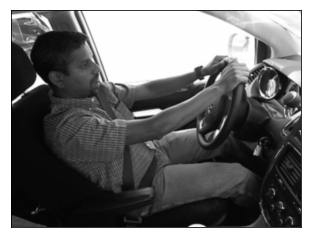

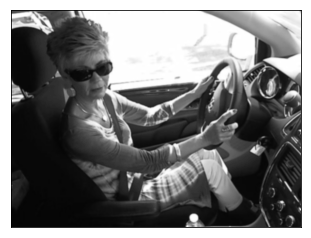

In [18]:
# image in grayscale
path = os.path.join('..', 'supervised', 'statefarm', 'c0', 'img_34.jpg')
img = cv2.imread(path,0)
plt.imshow(img, cmap='gray', interpolation='bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

# image in grayscale
path3 = os.path.join('..', 'supervised', 'statefarm', 'c0', 'img_139.jpg')
img_3 = cv2.imread(path3,0)

plt.imshow(img_3, cmap='gray', interpolation='bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

### Both images are from CLASS 0: Safe Driving.
One can make a strong argument that the bottom image should be not considered "safe driving".  
- Of course, the driver **could be** at a stop-sign intersection, checking her right side for any incoming cars.
- However, my **initial reaction** is that this is **not "safe driving"**.  
<br>
I do not believe that there is any information within the image that can provide an argument for "safe driving".  If this is all the information the dashboard cameras are given as well, then there are some **clear flaws.**  
<br><br>
Speaking from the perspective of someone who drives (pretty well if you were to ask), the only context in which the second image is "safe driving" is **if the driver is stopped at an intersection** and is checking for potential incoming traffic. 
<br><br>
However, as all of the images are taken from roughly the same camera angle, there is not any more information able to be extracted from one image than any other, as it pertains to the car's state
- In other words, if it cannot be determined from one image, then the other images ALSO are not able to make that determination
it can be assumed that it is **not possible** to be able to reach that conclusion given the **information in the image only.**

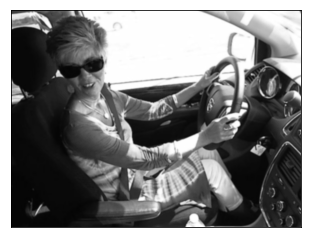

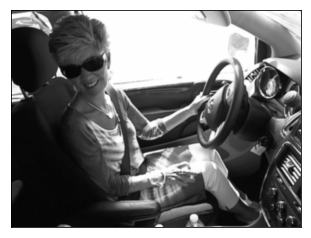

In [19]:
# # image in color
# path3 = os.path.join('..', 'supervised', 'statefarm', 'c0', 'img_3349.jpg')
# img_3 = cv2.imread(path3,1) # BGR format

# b,g,r = cv2.split(img_3)
# img3 = cv2.merge([r,g,b]) # RGB format

# plt.imshow(img3)
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
# plt.show()


# # image in color
# path3 = os.path.join('..', 'supervised', 'statefarm', 'c9', 'img_50.jpg')
# img_3 = cv2.imread(path3,1) # BGR format

# b,g,r = cv2.split(img_3)
# img3 = cv2.merge([r,g,b]) # RGB format

# plt.imshow(img3)
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
# plt.show()

# image in grayscale
path = os.path.join('..', 'supervised', 'statefarm', 'c0', 'img_3349.jpg')
img = cv2.imread(path,0)
plt.imshow(img, cmap='gray', interpolation='bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

# image in grayscale
path3 = os.path.join('..', 'supervised', 'statefarm', 'c9', 'img_50.jpg')
img_3 = cv2.imread(path3,0)

plt.imshow(img_3, cmap='gray', interpolation='bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

***

In [9]:
X, y, X_val, y_val, drivers_val = train_val_split(128,128,3,3)

Read train images
Load folder c0
Load folder c1
Load folder c2
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


In [10]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

#Create your own input format (here 3x200x200)
inp_img = Input(shape=(128,128,3),name='image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(inp_img)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(1000, activation='softmax')(x)
x = Dense(3, activation='softmax', name='predictions')(x)

#Create your own model 
my_model = Model(inputs=inp_img, outputs=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()


#Then training with your data ! 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [11]:
processed_image = preprocess_input(X).reshape(X.shape[0],128,128,3)

In [12]:
predictions = my_model.predict(processed_image)

In [13]:
predictions

array([[0.34230325, 0.32957312, 0.32812357],
       [0.32739225, 0.3379765 , 0.3346313 ],
       [0.33534437, 0.3382523 , 0.32640326],
       ...,
       [0.31518722, 0.34857118, 0.33624154],
       [0.3203067 , 0.3472765 , 0.33241683],
       [0.3304244 , 0.32835197, 0.34122363]], dtype=float32)

In [14]:
np.mean(y.astype(int)==np.argmax(predictions,axis=1))

0.3487742757083731

- must use vgg dimensions
- not enough computational memory

***


***
                                                                                                    - - side note
***
When, or if,  autonomous vehicles do become a thing, there would be **presumably no reason for dashboard cameras**.  
## *However*,
the journey to fully-autonomous vehicles was surely going to see a few controversies along the way.  
<br>
It is pretty clear that whoever comes out ahead of this technology race will place themselves directly into the esteemed FANG-tier of companies.  Some of the participants involved in this revolutionary new field include:
- of course, the [biggest players in the automotive industry](https://www.bloomberg.com/news/features/2018-05-07/who-s-winning-the-self-driving-car-race), 
- [a certain tech company](https://waymo.com/), 
- and just a handful of other companies...](https://www.wired.com/2017/05/mapped-top-263-companies-racing-toward-autonomous-cars/) 

<img src="../../../automated_industry.jpg" alt="Drawing" style="width: 950px;"/>

As business-to-business companies do not have the same public exposure as business-to-consumer companies, the number of companies involved in even the most obscurest industry segment can be unexpectedly high (if not, lower expectations). 
<br>
<br>
Such a booming field - especially one that has captured our imaginations since..."Back to the Future"? - was going to attract all sorts of people and businesses, which would of course include the somewhat dishonest, maybe slightly morally gray, overreaching narcissists, whose only wish is to be remembered as "the Steve Jobs" (not asking for much really).



As unfortunate and distressing as it is, with so many different companies involved in such a high-risk, high-reward new field, a [fatal accident involving autonomous vehicles](https://www.forbes.com/sites/meriameberboucha/2018/05/28/uber-self-driving-car-crash-what-really-happened/#46ba2d4d4dc4) did not seem all that unlikely.  
<br>
<br>
[Even the biggest companies with the most to lose](http://fortune.com/2015/09/18/mary-barra-gm-culture/) 
https://www.automotive-fleet.com/278700/uber-waymo-settle-autonomous-vehicle-technology-lawsuit
<img src="../../../autonomous_mckinnsey.png" alt="Drawing" style="width: 550px;"/>

<br>
<br>
There really is no reason to think that dashboard cameras **in all cars** can be implemented for ethical reasons, as dashboard cameras can be seen as an invasion of privacy.<br>
State Farm, and/or whoever else decides to public support dashboard cameras, can argue about the limitations of the cameras, how the images are thrown away if classified as safe driving and the non-safe driving images are transferred to a secure network, etc; they can expect to see some very impassioned protestors, while simultaneously gaining some ardent supporters. 
<br><br>
Thankfully, the ethicality of dashboard cameras is not our focus, as we are tasked with **determining if the classification of drivers' behaviors is achievable**. 
***
***
# Next Steps
<img src="../../../obj_det.png" alt="Drawing" style="width:550px;"/>

In [2]:
def create_model_vbottle(img_rows, img_cols, color_type, num_class, epochs, lr=1e-3):
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3),  activation='relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, activation='softmax'))

    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
    
#     model.compile(Adam(lr=lr, decay=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    return model